# 가짜연구소 4기 - 추천시스템 톺아보기
## UCI Online retail EDA
- 작성자: 김민수(kimminsu.ds@gmail.com)
- 출처: https://archive.ics.uci.edu/ml/datasets/online+retail#

#### Abstract
- This is a transaction data set which contains all the transactions occuring between 01/12/2010 and 09/12/2011 for a UK-based registered non-store online retail

#### Attritbute Information
- InvoiceNo: Invoce number
    - If this code starts with letter 'C', it indicates a cancellation
- StockCode: Product(item) code
- Description: Product(item) name
- Quantity: The quantities of each product (item) per transaction
- InvoceDate: The day and time when each transaction was generated
- UnitPrice: Product price per unit in sterling
- CustomerID: Customer number
- Country: The name of country where each customer resides

## 00. 환경설정

### 00-01. 패키지

In [1]:
%matplotlib inline

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

### 00-02. 데이터

#### 데이터 불러오기

In [2]:
df = pd.read_csv("../data/online_retail.csv")

#### 데이터 확인

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


#### 데이터 변환

In [6]:
df['CustomerID']  = df['CustomerID'].astype('str')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     541909 non-null object
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 33.1+ MB


#### `Description` 컬럼 Null 값 존재하므로 주의

In [8]:
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [9]:
numeric_col   = [x for x, y in zip(df.dtypes.index, df.dtypes) if y in ['float64', 'int64']]
category_col  = [x for x, y in zip(df.dtypes.index, df.dtypes) if y in ['object']]
date_col      = [x for x, y in zip(df.dtypes.index, df.dtypes) if y in ['datetime64[ns]']]

## 01. EDA

### InvoiceNo: Invoce number : 환불 데이터 제외
- If this code starts with letter 'C', it indicates a cancellation

In [10]:
idx = [i for i, x in zip(df.index, df.InvoiceNo) if x.startswith('C')]
idx[:5]

[141, 154, 235, 236, 237]

In [11]:
df.shape

(541909, 8)

In [12]:
df = df[~df.index.isin(idx)].reset_index(drop=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [13]:
df.shape

(532621, 8)

In [14]:
541909 - len(idx)

532621

### 01-01. Numeric columns

In [15]:
print(numeric_col)

['Quantity', 'UnitPrice']


In [16]:
df[numeric_col].describe()

,Quantity,UnitPrice
count,532621.000000,532621.000000
mean,10.239972,3.847621
std,159.593551,41.758023
min,-9600.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


#### Quantity: The quantities of each product (item) per transaction

- 환불 데이터를 제외했음에도 수량이 음수인 데이터가 존재 ->  삭제

In [17]:
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2380,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,nan,United Kingdom
4310,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,nan,United Kingdom
7105,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,nan,United Kingdom
7106,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,nan,United Kingdom
7107,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,nan,United Kingdom


In [18]:
df = df[df['Quantity'] >= 0].reset_index(drop=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [19]:
df['Quantity'].describe()

count    531285.000000
mean         10.655262
std         156.830323
min           1.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

- **`3분위수와 최댓값의 차이가 심함`**: 아웃라이어

In [20]:
np.percentile(df['Quantity'], 99.9)

480.0

In [21]:
df.loc[df['Quantity'] > np.percentile(df['Quantity'], 99.9)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
721,536437,17021,NAMASTE SWAGAT INCENSE,600,2010-12-01 12:12:00,0.24,13694.0,United Kingdom
3884,536736,22616,PACK OF 12 LONDON TISSUES,600,2010-12-02 12:59:00,0.29,17381.0,United Kingdom
4809,536809,84950,ASSORTED COLOUR T-LIGHT HOLDER,1824,2010-12-02 16:48:00,0.55,15299.0,United Kingdom
4873,536830,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,2880,2010-12-02 17:38:00,0.18,16754.0,United Kingdom
4874,536830,21915,RED HARMONICA IN BOX,1400,2010-12-02 17:38:00,1.06,16754.0,United Kingdom
...,...,...,...,...,...,...,...,...
527303,581375,21137,BLACK RECORD COVER FRAME,960,2011-12-08 12:36:00,3.39,16210.0,United Kingdom
529463,581457,23543,WALL ART KEEP CALM,698,2011-12-08 18:43:00,4.15,18102.0,United Kingdom
529472,581458,22197,POPCORN HOLDER,1500,2011-12-08 18:45:00,0.72,17949.0,United Kingdom
529473,581459,22197,POPCORN HOLDER,1200,2011-12-08 18:46:00,0.72,17949.0,United Kingdom


#### UnitPrice: Product price per unit in sterling

In [22]:
df[numeric_col].describe()

,Quantity,UnitPrice
count,531285.000000,531285.000000
mean,10.655262,3.857296
std,156.830323,41.810047
min,1.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


- 환불 데이터를 제거했음에도 가격이 음수 or 0인 데이터가 존재 -> 삭제

In [23]:
df[df['UnitPrice'] <= 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
613,536414,22139,NaN,56,2010-12-01 11:52:00,0.0,nan,United Kingdom
1958,536545,21134,NaN,1,2010-12-01 14:32:00,0.0,nan,United Kingdom
1959,536546,22145,NaN,1,2010-12-01 14:33:00,0.0,nan,United Kingdom
1960,536547,37509,NaN,1,2010-12-01 14:33:00,0.0,nan,United Kingdom
1961,536549,85226A,NaN,1,2010-12-01 14:34:00,0.0,nan,United Kingdom


In [24]:
df = df[df['UnitPrice'] > 0].reset_index(drop=True)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [25]:
df[numeric_col].describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


- **`3분위수와 최댓값의 차이가 심함`**: 아웃라이어

In [26]:
np.percentile(df['UnitPrice'], 99.9)

165.0

In [27]:
df.loc[df['UnitPrice'] > np.percentile(df['UnitPrice'], 99.9)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1801,536544,DOT,DOTCOM POSTAGE,1,2010-12-01 14:32:00,569.77,nan,United Kingdom
3005,536592,DOT,DOTCOM POSTAGE,1,2010-12-01 17:06:00,607.49,nan,United Kingdom
4907,536835,22655,VINTAGE RED KITCHEN CABINET,1,2010-12-02 18:06:00,295.00,13145.0,United Kingdom
5358,536862,DOT,DOTCOM POSTAGE,1,2010-12-03 11:13:00,254.43,nan,United Kingdom
5593,536865,DOT,DOTCOM POSTAGE,1,2010-12-03 11:28:00,498.47,nan,United Kingdom
...,...,...,...,...,...,...,...,...
525109,581219,DOT,DOTCOM POSTAGE,1,2011-12-08 09:28:00,1008.96,nan,United Kingdom
525506,581238,DOT,DOTCOM POSTAGE,1,2011-12-08 10:53:00,1683.75,nan,United Kingdom
527589,581439,DOT,DOTCOM POSTAGE,1,2011-12-08 16:30:00,938.59,nan,United Kingdom
529107,581492,DOT,DOTCOM POSTAGE,1,2011-12-09 10:03:00,933.17,nan,United Kingdom


### 01-02. Category columns

In [28]:
category_col

['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']

### InvoiceNo: Invoce number
- If this code starts with letter 'C', it indicates a cancellation

In [29]:
df['InvoiceNo'].nunique()

19960

In [30]:
df['InvoiceNo'].value_counts().mean()

26.558316633266532

In [31]:
df['InvoiceNo'].value_counts()

573585    1114
581219     749
581492     731
580729     721
558475     705
          ... 
570493       1
537836       1
559522       1
537194       1
570848       1
Name: InvoiceNo, Length: 19960, dtype: int64

In [32]:
df['InvoiceNo'].value_counts().mean()

26.558316633266532

- **`평균에 비해 너무 많이 등장하는 데이터 존재`**: 아웃라이어

In [33]:
df[df['InvoiceNo']=='573585']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
420202,573585,11001,ASSTD DESIGN RACING CAR PEN,2,2011-10-31 14:41:00,3.29,nan,United Kingdom
420203,573585,15036,ASSORTED COLOURS SILK FAN,15,2011-10-31 14:41:00,1.63,nan,United Kingdom
420204,573585,15039,SANDALWOOD FAN,15,2011-10-31 14:41:00,1.63,nan,United Kingdom
420205,573585,15056BL,EDWARDIAN PARASOL BLACK,1,2011-10-31 14:41:00,12.46,nan,United Kingdom
420206,573585,15056N,EDWARDIAN PARASOL NATURAL,1,2011-10-31 14:41:00,12.46,nan,United Kingdom
...,...,...,...,...,...,...,...,...
421311,573585,90209C,PINK ENAMEL+GLASS HAIR COMB,3,2011-10-31 14:41:00,2.07,nan,United Kingdom
421312,573585,90214S,"LETTER ""S"" BLING KEY RING",1,2011-10-31 14:41:00,0.83,nan,United Kingdom
421313,573585,DOT,DOTCOM POSTAGE,1,2011-10-31 14:41:00,2019.05,nan,United Kingdom
421314,573585,gift_0001_20,Dotcomgiftshop Gift Voucher £20.00,1,2011-10-31 14:41:00,16.67,nan,United Kingdom


In [34]:
category_col

['InvoiceNo', 'StockCode', 'Description', 'CustomerID', 'Country']

###  StockCode: Product(item) code

In [35]:
df['StockCode'].nunique()

3922

In [36]:
df['StockCode'].value_counts()

85123A    2265
85099B    2112
22423     2017
47566     1706
20725     1595
          ... 
90142A       1
90167        1
22528        1
84854        1
22323        1
Name: StockCode, Length: 3922, dtype: int64

- 가장 많이 등장하는 StockCode는 85123A
- **`StockCode와 Description은 1대1 매칭되지 않음`**

In [37]:
df[df['StockCode']=='85123A']['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER',
       'CREAM HANGING HEART T-LIGHT HOLDER'], dtype=object)

In [38]:
df[df['StockCode']=='85099B']['Description'].unique()

array(['JUMBO BAG RED RETROSPOT'], dtype=object)

In [39]:
df[df['StockCode']=='22423']['Description'].unique()

array(['REGENCY CAKESTAND 3 TIER'], dtype=object)

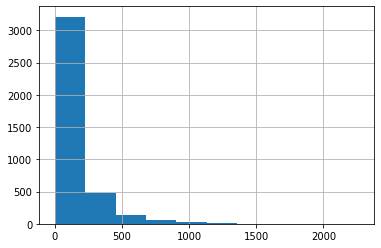

In [40]:
df['StockCode'].value_counts().hist()
plt.show()

### Desription: Product(item) name

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 530104 entries, 0 to 530103
Data columns (total 8 columns):
InvoiceNo      530104 non-null object
StockCode      530104 non-null object
Description    530104 non-null object
Quantity       530104 non-null int64
InvoiceDate    530104 non-null datetime64[ns]
UnitPrice      530104 non-null float64
CustomerID     530104 non-null object
Country        530104 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 32.4+ MB


In [42]:
df['Description'].nunique()

4026

- 가장 많이 등장하는 Description은 WHITE HANGING HEART T-LIGHT HOLDER

In [43]:
df['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2323
JUMBO BAG RED RETROSPOT               2112
REGENCY CAKESTAND 3 TIER              2017
PARTY BUNTING                         1706
LUNCH BAG RED RETROSPOT               1594
                                      ... 
S/4 BLACK DISCO PARTITION PANEL          1
ORANGE/FUSCHIA STONES NECKLACE           1
CROCHET LILAC/RED BEAR KEYRING           1
DOORKNOB CERAMIC IVORY                   1
JARDIN ETCHED GLASS BUTTER DISH          1
Name: Description, Length: 4026, dtype: int64

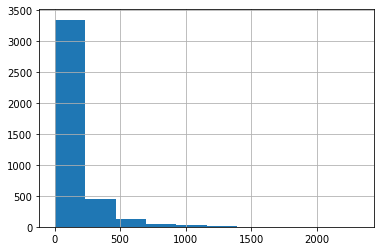

In [44]:
df['Description'].value_counts().hist()
plt.show()

### CustomerID: Customer number

In [45]:
df['CustomerID'].nunique()

4339

- **`Null값 존재`**

In [46]:
df['CustomerID'].value_counts()

nan        132220
17841.0      7847
14911.0      5675
14096.0      5111
12748.0      4595
            ...  
16148.0         1
15524.0         1
13302.0         1
18068.0         1
16990.0         1
Name: CustomerID, Length: 4339, dtype: int64

In [47]:
df['CustomerID'].value_counts().mean()

122.17192901590228

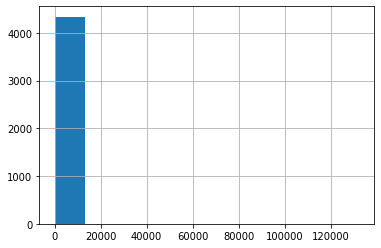

In [48]:
df['CustomerID'].value_counts().hist()
plt.show()

### Country: The name of country where each customer resides

In [49]:
df['Country'].nunique()

38

In [50]:
df['Country'].value_counts()

United Kingdom          485123
Germany                   9040
France                    8407
EIRE                      7890
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1966
Portugal                  1501
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Unspecified                446
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     295
Hong Kong                  284
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon 

## 02. Summary

### InvoiceNo: Invoce number : 환불 데이터 제외
- If this code starts with letter 'C', it indicates a cancellation

#### Quantity: The quantities of each product (item) per transaction
- 환불 데이터를 제외했음에도 수량이 음수인 데이터가 존재 ->  삭제
- 3분위수와 최댓값의 차이가 심함: 아웃라이어

#### UnitPrice: Product price per unit in sterling
- 환불 데이터를 제거했음에도 가격이 음수 or 0인 데이터가 존재 -> 삭제
- 3분위수와 최댓값의 차이가 심함: 아웃라이어

### InvoiceNo: Invoce number
- 평균에 비해 너무 많이 등장하는 데이터 존재: 아웃라이어

###  StockCode: Product(item) code
- 가장 많이 등장하는 StockCode는 85123A
- StockCode와 Description은 1대1 매칭되지 않음

In [51]:
df['StockCode'].nunique()

3922

In [52]:
df[df['StockCode']=='85123A']['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER',
       'CREAM HANGING HEART T-LIGHT HOLDER'], dtype=object)

### Description: Product(item) name

- 가장 많이 등장하는 Description은 WHITE HANGING HEART T-LIGHT HOLDER

In [53]:
df['Description'].nunique()

4026

In [54]:
df['Description'].value_counts()[:1]

WHITE HANGING HEART T-LIGHT HOLDER    2323
Name: Description, dtype: int64

### CustomerID: Customer number
- Null값 존재 -> 분석 목적에 따라 삭제

In [55]:
df['CustomerID'].nunique()

4339

In [56]:
df['CustomerID'].value_counts()[:3]

nan        132220
17841.0      7847
14911.0      5675
Name: CustomerID, dtype: int64

### Country: The name of country where each customer resides
- 총 38개 국가
- 91.5%는 영국

In [57]:
df['Country'].nunique()

38

In [58]:
df['Country'].value_counts()[:5]

United Kingdom    485123
Germany             9040
France              8407
EIRE                7890
Spain               2484
Name: Country, dtype: int64

In [59]:
df['Country'].value_counts(normalize=True)[:5]*100

United Kingdom    91.514684
Germany            1.705326
France             1.585915
EIRE               1.488387
Spain              0.468587
Name: Country, dtype: float64

## 03. RFM 예제 - Cookie

In [60]:
cookie_idx =  [i for i, x in zip(df.index, df["Description"]) if 'COOKIE' in x]
len(cookie_idx)

3305

In [61]:
cookie_df = df[df.index.isin(cookie_idx)].reset_index(drop=True)
cookie_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536404,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom
1,536404,84378,SET OF 3 HEART COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom
2,536404,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,12,2010-12-01 11:29:00,2.10,16218.0,United Kingdom
3,536408,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,6,2010-12-01 11:41:00,2.10,14307.0,United Kingdom
4,536408,84375,SET OF 20 KIDS COOKIE CUTTERS,12,2010-12-01 11:41:00,2.10,14307.0,United Kingdom


#### RFM은 고객별로 계산되므로  CustomerID Null값 데이터 제외

In [62]:
cookie_df[cookie_df['CustomerID']=='nan'].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
8,536544,22966,GINGERBREAD MAN COOKIE CUTTER,3,2010-12-01 14:32:00,2.51,nan,United Kingdom
9,536544,84375,SET OF 20 KIDS COOKIE CUTTERS,4,2010-12-01 14:32:00,4.21,nan,United Kingdom
10,536544,84378,SET OF 3 HEART COOKIE CUTTERS,1,2010-12-01 14:32:00,2.51,nan,United Kingdom
11,536544,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,5,2010-12-01 14:32:00,2.51,nan,United Kingdom
15,536592,84375,SET OF 20 KIDS COOKIE CUTTERS,1,2010-12-01 17:06:00,4.21,nan,United Kingdom


In [63]:
cookie_df = cookie_df[cookie_df['CustomerID']!='nan'].reset_index(drop=True)
cookie_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536404,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom
1,536404,84378,SET OF 3 HEART COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom
2,536404,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,12,2010-12-01 11:29:00,2.10,16218.0,United Kingdom
3,536408,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,6,2010-12-01 11:41:00,2.10,14307.0,United Kingdom
4,536408,84375,SET OF 20 KIDS COOKIE CUTTERS,12,2010-12-01 11:41:00,2.10,14307.0,United Kingdom


#### 분석기간 설정  - 2011년 12월 09일 기준으로 최근 1년 이내

In [64]:
cookie_df.InvoiceDate.min()

Timestamp('2010-12-01 11:29:00')

In [65]:
cookie_df.InvoiceDate.max()

Timestamp('2011-12-09 11:34:00')

### 03-01. R(Recency) 계산
- 고객의 가장 최근 해당 물품 구매일자 -> 최근에 구매했을수록 높은 점수

In [66]:
cookie_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536404,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom
1,536404,84378,SET OF 3 HEART COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom
2,536404,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,12,2010-12-01 11:29:00,2.10,16218.0,United Kingdom
3,536408,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,6,2010-12-01 11:41:00,2.10,14307.0,United Kingdom
4,536408,84375,SET OF 20 KIDS COOKIE CUTTERS,12,2010-12-01 11:41:00,2.10,14307.0,United Kingdom


#### 2011년 12월 09일(target date) 기준으로 해당 거래가 얼마나 지났는지 계산

In [67]:
from datetime import *

target_date = datetime.date(datetime.strptime("2011-12-09", '%Y-%m-%d'))
target_date

datetime.date(2011, 12, 9)

In [68]:
cookie_df['cookie_R'] = cookie_df['InvoiceDate'].apply(lambda x: datetime.date(x) - target_date)
cookie_df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cookie_R
0,536404,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom,-373 days
1,536404,84378,SET OF 3 HEART COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom,-373 days
2,536404,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,12,2010-12-01 11:29:00,2.10,16218.0,United Kingdom,-373 days
3,536408,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,6,2010-12-01 11:41:00,2.10,14307.0,United Kingdom,-373 days
4,536408,84375,SET OF 20 KIDS COOKIE CUTTERS,12,2010-12-01 11:41:00,2.10,14307.0,United Kingdom,-373 days
...,...,...,...,...,...,...,...,...,...
2592,581456,22966,GINGERBREAD MAN COOKIE CUTTER,5,2011-12-08 18:42:00,1.25,17530.0,United Kingdom,-1 days
2593,581456,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,1,2011-12-08 18:42:00,1.45,17530.0,United Kingdom,-1 days
2594,581456,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,2,2011-12-08 18:42:00,2.10,17530.0,United Kingdom,-1 days
2595,581538,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,1,2011-12-09 11:34:00,1.45,14446.0,United Kingdom,0 days


In [69]:
rfm_df = cookie_df.groupby(['CustomerID'])['cookie_R'].max().reset_index()
rfm_df

,CustomerID,cookie_R
0,12356.0,-245 days
1,12357.0,-33 days
2,12360.0,-52 days
3,12362.0,-35 days
4,12378.0,-129 days
...,...,...
932,18252.0,-50 days
933,18260.0,-334 days
934,18265.0,-158 days
935,18272.0,-2 days


### 03-2. F(Frequency) 계산
- 고객이 분석 기간 내 해당 물품을 구매한 빈도 수

In [70]:
cookie_df.groupby(['CustomerID']).size().rename('cookie_F')

CustomerID
12356.0     4
12357.0     3
12360.0     1
12362.0     1
12378.0     4
           ..
18252.0     1
18260.0     1
18265.0     1
18272.0    11
18283.0     6
Name: cookie_F, Length: 937, dtype: int64

In [71]:
rfm_df['cookie_F']  = list(cookie_df.groupby(['CustomerID']).size())
rfm_df

,CustomerID,cookie_R,cookie_F
0,12356.0,-245 days,4
1,12357.0,-33 days,3
2,12360.0,-52 days,1
3,12362.0,-35 days,1
4,12378.0,-129 days,4
...,...,...,...
932,18252.0,-50 days,1
933,18260.0,-334 days,1
934,18265.0,-158 days,1
935,18272.0,-2 days,11


### 03-03. M(Monetary) 계산
- 고객이 분석 기간 내 해당 물품에 사용한 총 금액

In [72]:
cookie_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cookie_R
0,536404,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom,-373 days
1,536404,84378,SET OF 3 HEART COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom,-373 days
2,536404,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,12,2010-12-01 11:29:00,2.10,16218.0,United Kingdom,-373 days
3,536408,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,6,2010-12-01 11:41:00,2.10,14307.0,United Kingdom,-373 days
4,536408,84375,SET OF 20 KIDS COOKIE CUTTERS,12,2010-12-01 11:41:00,2.10,14307.0,United Kingdom,-373 days


In [73]:
cookie_df['TotalPrice'] = cookie_df['Quantity'] * cookie_df['UnitPrice']
cookie_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,cookie_R,TotalPrice
0,536404,84380,SET OF 3 BUTTERFLY COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom,-373 days,15.0
1,536404,84378,SET OF 3 HEART COOKIE CUTTERS,12,2010-12-01 11:29:00,1.25,16218.0,United Kingdom,-373 days,15.0
2,536404,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,12,2010-12-01 11:29:00,2.10,16218.0,United Kingdom,-373 days,25.2
3,536408,22964,3 PIECE SPACEBOY COOKIE CUTTER SET,6,2010-12-01 11:41:00,2.10,14307.0,United Kingdom,-373 days,12.6
4,536408,84375,SET OF 20 KIDS COOKIE CUTTERS,12,2010-12-01 11:41:00,2.10,14307.0,United Kingdom,-373 days,25.2


In [74]:
cookie_df.groupby(['CustomerID'])['TotalPrice'].sum()

CustomerID
12356.0    169.35
12357.0     72.60
12360.0     25.20
12362.0     25.20
12378.0     57.60
            ...  
18252.0      4.15
18260.0     15.00
18265.0     15.00
18272.0    187.80
18283.0      9.20
Name: TotalPrice, Length: 937, dtype: float64

In [75]:
rfm_df['cookie_M']  = list(cookie_df.groupby(['CustomerID'])['TotalPrice'].sum())
rfm_df

,CustomerID,cookie_R,cookie_F,cookie_M
0,12356.0,-245 days,4,169.35
1,12357.0,-33 days,3,72.60
2,12360.0,-52 days,1,25.20
3,12362.0,-35 days,1,25.20
4,12378.0,-129 days,4,57.60
...,...,...,...,...
932,18252.0,-50 days,1,4.15
933,18260.0,-334 days,1,15.00
934,18265.0,-158 days,1,15.00
935,18272.0,-2 days,11,187.80


### 03-04. Score 계산
- RFM에 가중치를 주어 Cookie Score 계산
    - 가중치의 합은 1
- 항목별 단위가 다르므로 정규화 필요
- 항목별 가중치의 비중은 품목에 따라 달라짐

In [76]:
rfm_df['cookie_R'] = rfm_df['cookie_R'].apply(lambda  x: int(str(x).split(" days")[0]))
rfm_df

,CustomerID,cookie_R,cookie_F,cookie_M
0,12356.0,-245,4,169.35
1,12357.0,-33,3,72.60
2,12360.0,-52,1,25.20
3,12362.0,-35,1,25.20
4,12378.0,-129,4,57.60
...,...,...,...,...
932,18252.0,-50,1,4.15
933,18260.0,-334,1,15.00
934,18265.0,-158,1,15.00
935,18272.0,-2,11,187.80


#### 항목별 Min-Max scaling

In [77]:
rfm_df['cookie_R'].describe()

count    937.000000
mean    -134.286019
std      114.600390
min     -373.000000
25%     -233.000000
50%      -88.000000
75%      -35.000000
max        0.000000
Name: cookie_R, dtype: float64

- cookie_R 최솟값 index 확인 - 386

In [78]:
rfm_df[rfm_df['cookie_R']==rfm_df['cookie_R'].min()]

,CustomerID,cookie_R,cookie_F,cookie_M
386,14729.0,-373,1,1.25
613,16218.0,-373,3,55.20
859,17760.0,-373,1,8.40


- cookie_R 최댓값 index 확인 - 334

In [79]:
rfm_df[rfm_df['cookie_R']==rfm_df['cookie_R'].max()]

,CustomerID,cookie_R,cookie_F,cookie_M
334,14446.0,0,2,7.25


#### MinMax Scaler 정의
- 최솟값을 0으로, 최댓값을 1로 변환

In [80]:
def min_max_scaler(x):
    return (x - x.min()) / (x.max() - x.min())

In [81]:
rfm_df['cookie_R'] = min_max_scaler(rfm_df['cookie_R'])
rfm_df

,CustomerID,cookie_R,cookie_F,cookie_M
0,12356.0,0.343164,4,169.35
1,12357.0,0.911528,3,72.60
2,12360.0,0.860590,1,25.20
3,12362.0,0.906166,1,25.20
4,12378.0,0.654155,4,57.60
...,...,...,...,...
932,18252.0,0.865952,1,4.15
933,18260.0,0.104558,1,15.00
934,18265.0,0.576408,1,15.00
935,18272.0,0.994638,11,187.80


- cookie_R 최솟값 index 확인 - 386
- cookie_R 최댓값 index 확인 - 334

In [82]:
rfm_df.iloc[[386, 334]]

,CustomerID,cookie_R,cookie_F,cookie_M
386,14729.0,0.0,1,1.25
334,14446.0,1.0,2,7.25


- F, M도 MinMax Scale

In [83]:
rfm_df['cookie_F'] = min_max_scaler(rfm_df['cookie_F'])
rfm_df['cookie_M'] = min_max_scaler(rfm_df['cookie_M'])
rfm_df

,CustomerID,cookie_R,cookie_F,cookie_M
0,12356.0,0.343164,0.069767,0.066041
1,12357.0,0.911528,0.046512,0.028031
2,12360.0,0.860590,0.000000,0.009409
3,12362.0,0.906166,0.000000,0.009409
4,12378.0,0.654155,0.069767,0.022138
...,...,...,...,...
932,18252.0,0.865952,0.000000,0.001139
933,18260.0,0.104558,0.000000,0.005402
934,18265.0,0.576408,0.000000,0.005402
935,18272.0,0.994638,0.232558,0.073289


#### 각 항목별 가중치 정의 후 최종 스코어 계산
- R(0.3), F(0.3), M(0.4)

In [84]:
rfm_df['cookie_S'] = rfm_df['cookie_R'] * 0.3 +  rfm_df['cookie_F'] * 0.3 + rfm_df['cookie_M']  * 0.4
rfm_df

,CustomerID,cookie_R,cookie_F,cookie_M,cookie_S
0,12356.0,0.343164,0.069767,0.066041,0.150296
1,12357.0,0.911528,0.046512,0.028031,0.298624
2,12360.0,0.860590,0.000000,0.009409,0.261941
3,12362.0,0.906166,0.000000,0.009409,0.275614
4,12378.0,0.654155,0.069767,0.022138,0.226032
...,...,...,...,...,...
932,18252.0,0.865952,0.000000,0.001139,0.260241
933,18260.0,0.104558,0.000000,0.005402,0.033528
934,18265.0,0.576408,0.000000,0.005402,0.175083
935,18272.0,0.994638,0.232558,0.073289,0.397475


In [85]:
rfm_df = rfm_df.sort_values(by=['cookie_S'], ascending=False).reset_index(drop=True)
rfm_df

,CustomerID,cookie_R,cookie_F,cookie_M,cookie_S
0,14911.0,0.994638,1.000000,0.666032,0.864804
1,14646.0,0.957105,0.395349,1.000000,0.805736
2,14096.0,0.989276,0.976744,0.137621,0.644855
3,12901.0,0.973190,0.209302,0.650128,0.614799
4,14796.0,0.997319,0.651163,0.052998,0.515744
...,...,...,...,...,...
932,14396.0,0.005362,0.000000,0.000334,0.001742
933,17760.0,0.000000,0.000000,0.002809,0.001124
934,15923.0,0.002681,0.000000,0.000334,0.000938
935,16916.0,0.002681,0.000000,0.000000,0.000804
